<a href="https://colab.research.google.com/github/DrDoogie/OpenCV/blob/main/TensorFlow_EuroSAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt

#Tensorflow Database활용
import tensorflow_datasets as tfds


In [ ]:
#EuroSAT 위성 사진 데이터셋 로드

DATA_DIR = "dataset/"

(train_ds, valid_ds), info = tfds.load('eurosat', split=['train[:80%]','train[80%:]'],
                                     shuffle_files=True,
                                     as_supervised=True,
                                     with_info=True,
                                     data_dir=DATA_DIR)

print(train_ds)
print(valid_ds)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling dataset/eurosat/rgb/incomplete.9Z3YWC_2.0.0/eurosat-train.tfrecord*...:   0%|          | 0/27000 [00…

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='dataset/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'l

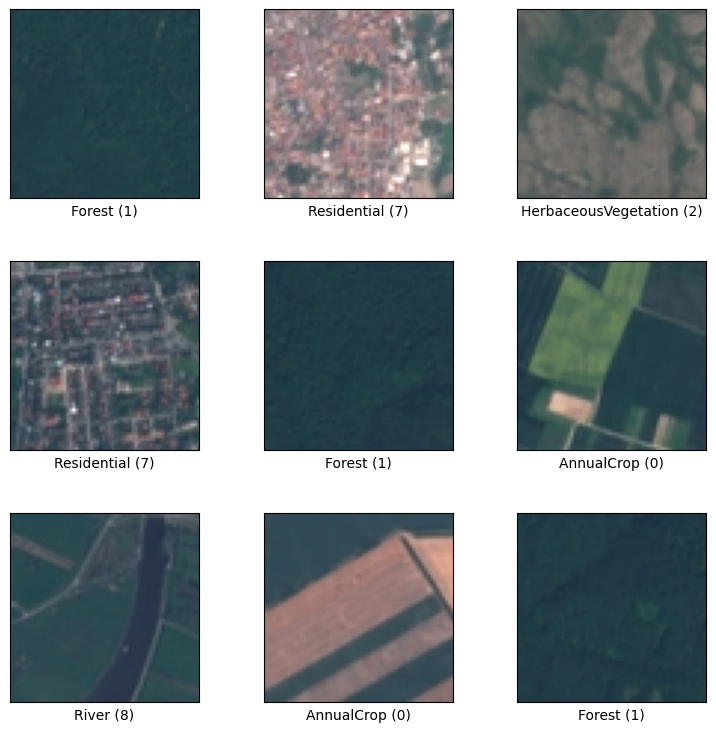

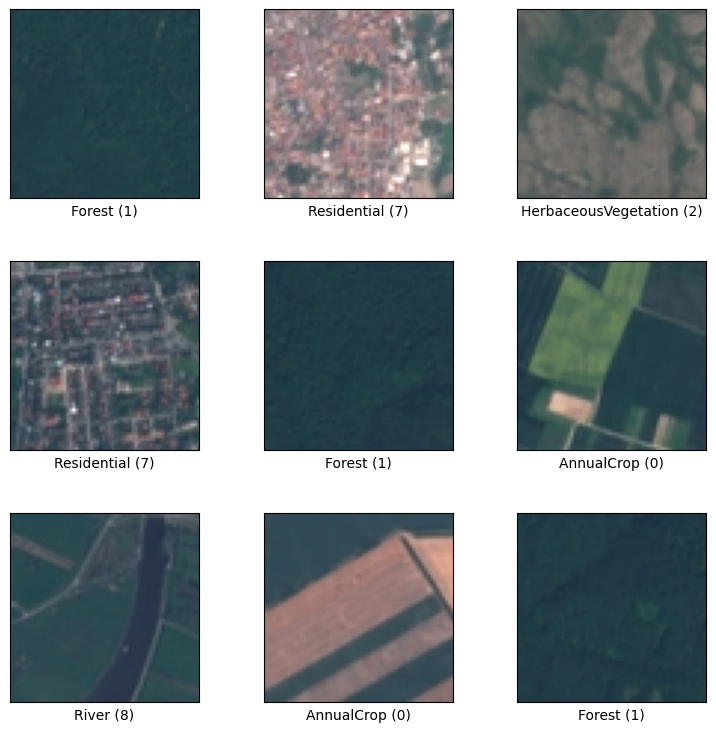

In [ ]:

#데이터확인
tfds.show_examples(train_ds, info)

image  label
0  [[[56, 84, 121], [56, 85, 119], [67, 94, 124],...      5
1  [[[102, 105, 112], [105, 104, 110], [116, 107,...      7
2  [[[82, 98, 97], [83, 97, 97], [86, 97, 99], [9...      0
3  [[[56, 72, 87], [56, 72, 87], [52, 70, 82], [5...      1
4  [[[219, 154, 126], [218, 153, 125], [220, 154,...      0
5  [[[69, 83, 84], [67, 83, 83], [65, 80, 85], [6...      2
6  [[[28, 52, 76], [28, 52, 76], [31, 51, 75], [3...      9
7  [[[45, 75, 77], [46, 74, 78], [49, 69, 78], [6...      8
8  [[[135, 127, 124], [135, 127, 124], [132, 127,...      2
9  [[[40, 55, 74], [40, 55, 74], [41, 56, 75], [3...      9
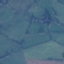
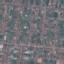
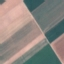
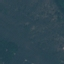
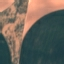
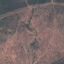
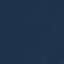
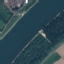
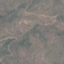
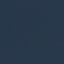

In [ ]:
#as_dataframe

tfds.as_dataframe(valid_ds.take(10),info)

In [ ]:
NUM_CLASSES=info.features['label'].num_classes
print(NUM_CLASSES)

10


In [ ]:
print(info.features["label"].int2str(6))

PermanentCrop


In [ ]:
BATCH_SIZE=64
BUFFER_SIZE=1000

def preprocess_data(image,label):
  image=tf.cast(image, tf.float32)/255
  return image, label

train_data=train_ds.map(preprocess_data,num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_data=valid_ds.map(preprocess_data,num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_data=train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
valid_data=valid_data.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
def build_model():
  model= tf.keras.Sequential([
      #convolution
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32,3,padding='same',activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128,activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64,activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
  ])


  return model

model = build_model()

In [ ]:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history=model.fit(train_data,
                  validation_data=valid_data,
                  epochs=5)

NameError: name 'model' is not defined

In [ ]:
def plot_loss_acc(history,epoch):
  loss,val_loss=history.history['loss'],history.history['val_loss']
  acc,val_acc=history.history['accuracy'],history.history['val_accuracy']

  fig,axes=plt.subplots(1,2,figsize=(12,4))

  axes[0].plot(range(1,epoch+1),loss,label='Training')
  axes[0].plot(range(1,epoch+1),val_loss,label='Validation')
  axes[0].legend(loc='best')
  axes[0].set_title('Loss')

  axes[1].plot(range(1,epoch+1),acc, label='Taining')
  axes[1].plot(range(1,epoch+1),val_acc, label='Validation')
  axes[0].legend(loc='best')
  axes[0].set_title('Accuracy')

  plt.show()

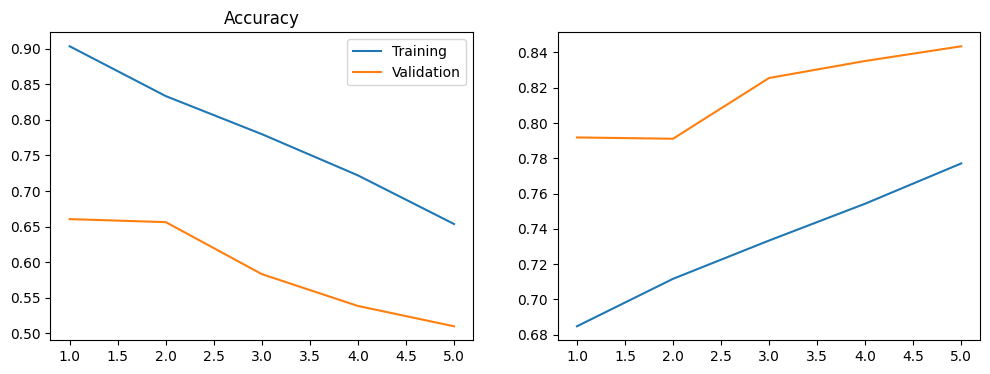

In [ ]:

plot_loss_acc(history,5)

Text(0.5, 1.0, 'SeaLake')

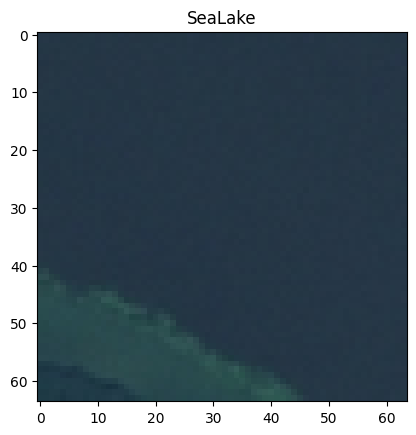

In [ ]:
image_batch,label_batch=next(iter(train_data.take(1)))

image=image_batch[0]
label=label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features['label'].int2str(label))


In [ ]:
def plot_augmentation(original,augmented):

  fig,axes = plt.subplots(1,2,figsize=(12,4))

  axes[0].imshow(original)
  axes[0].set_title('Original')

  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')

  plt.show()

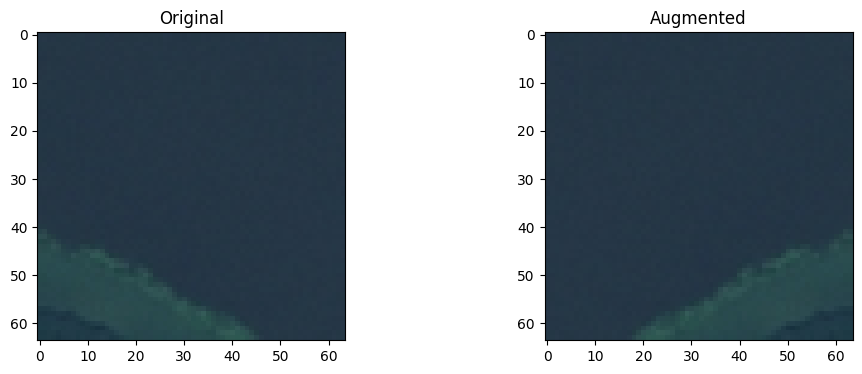

In [ ]:
lr_flip=tf.image.flip_left_right(image)
plot_augmentation(image,lr_flip)

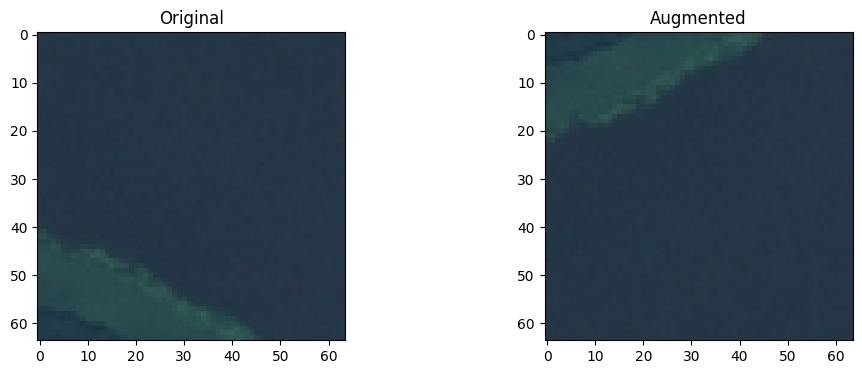

In [ ]:
up_flip=tf.image.flip_up_down(image)
plot_augmentation(image,up_flip)

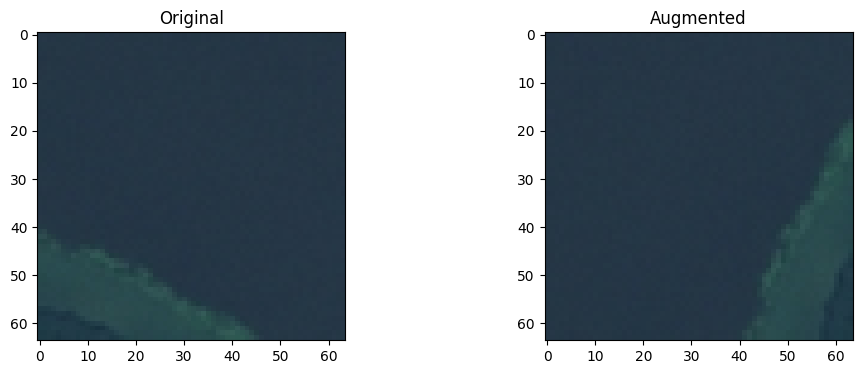

In [ ]:
rotate90=tf.image.rot90(image)
plot_augmentation(image,rotate90)

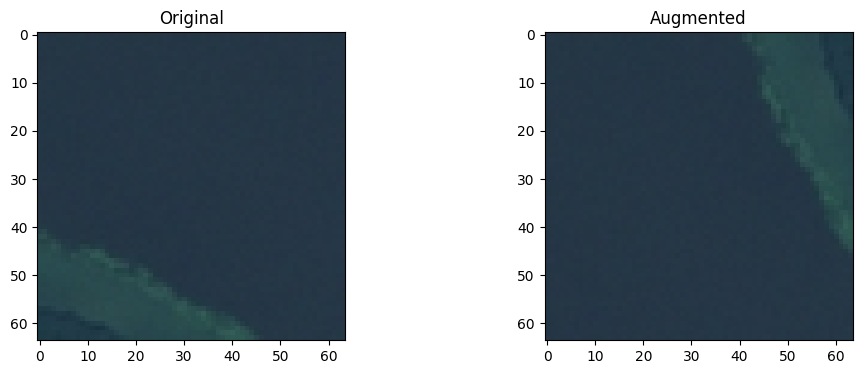

In [ ]:
transpose=tf.image.transpose(image)
plot_augmentation(image,transpose)
#

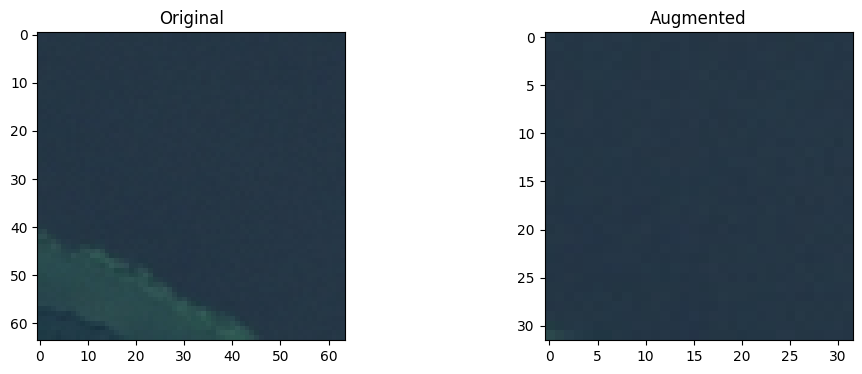

In [ ]:
crop1=tf.image.central_crop(image,0.5)
plot_augmentation(image,crop1)

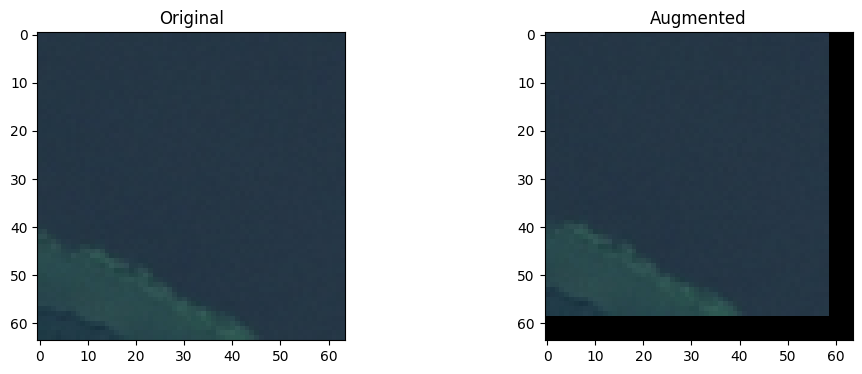

In [ ]:
img=tf.image.resize_with_crop_or_pad(image,64+20,64+20) #사이즈 키우기
crop2=tf.image.random_crop(img,(64,64,3))
plot_augmentation(image,crop2)

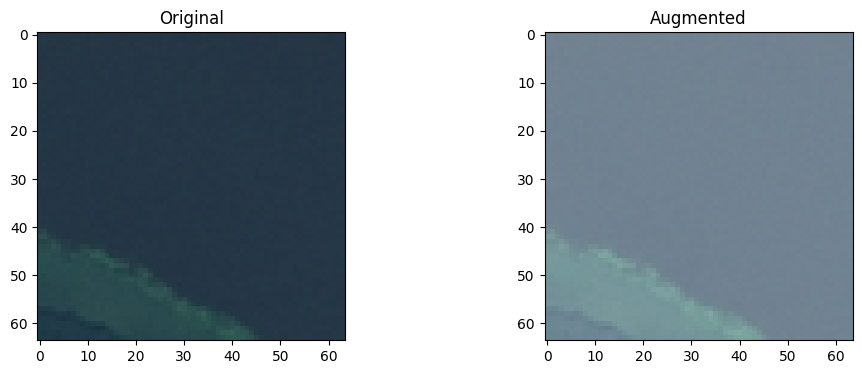

In [ ]:
brightness=tf.image.adjust_brightness(image,delta=0.3)
plot_augmentation(image,brightness)

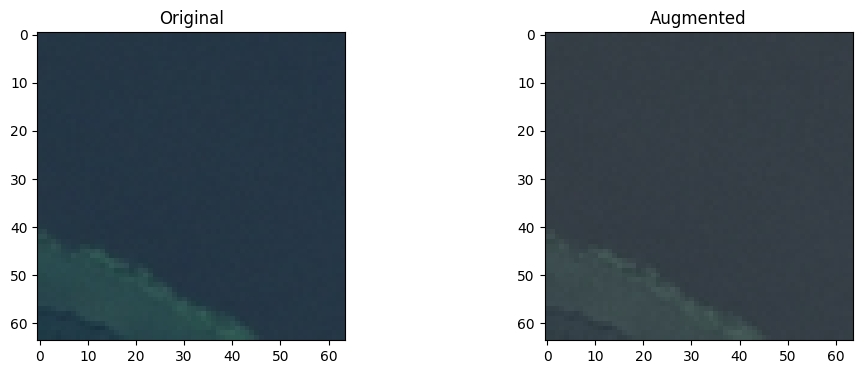

In [ ]:
saturation=tf.image.adjust_saturation(image,saturation_factor=0.5)
plot_augmentation(image,saturation)

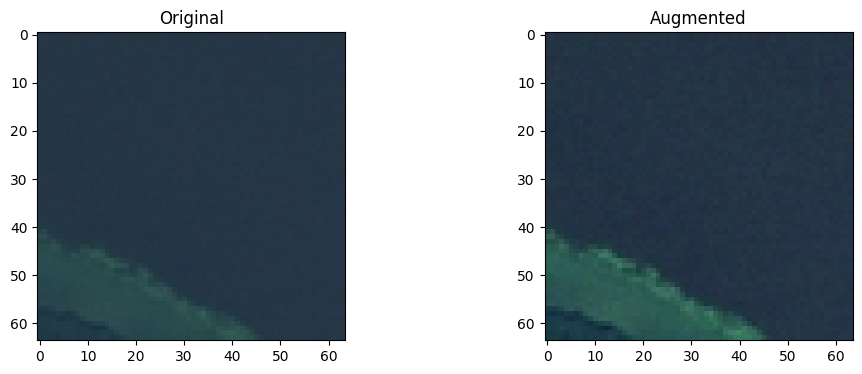

In [ ]:
contrast=tf.image.adjust_contrast(images=image,contrast_factor=2)
plot_augmentation(image,contrast)

In [ ]:
def data_augmentation(image,label):

  image=tf.image.random_flip_left_right(image)
  image=tf.image.random_flip_up_down(image)
  image=tf.image.random_brightness(image,max_delta=0.3)
  image=tf.image.random_crop(image,size=(64,64,3))

  image= tf.cast(image,tf.float32)/255

  return image,label

train_aug = train_ds.map(data_augmentation,num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation,num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
aug_model=build_model()

aug_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

aug_history=aug_model.fit(train_aug,
                          validation_data=valid_aug,
                          epochs=5)

Epoch 1/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 121s 348ms/step - accuracy: 0.2669 - loss: 2.0796 - val_accuracy: 0.4285 - val_loss: 1.6351
Epoch 2/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 136s 402ms/step - accuracy: 0.4028 - loss: 1.5750 - val_accuracy: 0.4959 - val_loss: 1.3923
Epoch 3/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 137s 403ms/step - accuracy: 0.4643 - loss: 1.4299 - val_accuracy: 0.5489 - val_loss: 1.2230
Epoch 4/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 118s 334ms/step - accuracy: 0.5206 - loss: 1.3048 - val_accuracy: 0.6324 - val_loss: 1.0341
Epoch 5/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 161s 390ms/step - accuracy: 0.5442 - loss: 1.2348 - val_accuracy: 0.6361 - val_loss: 1.1023


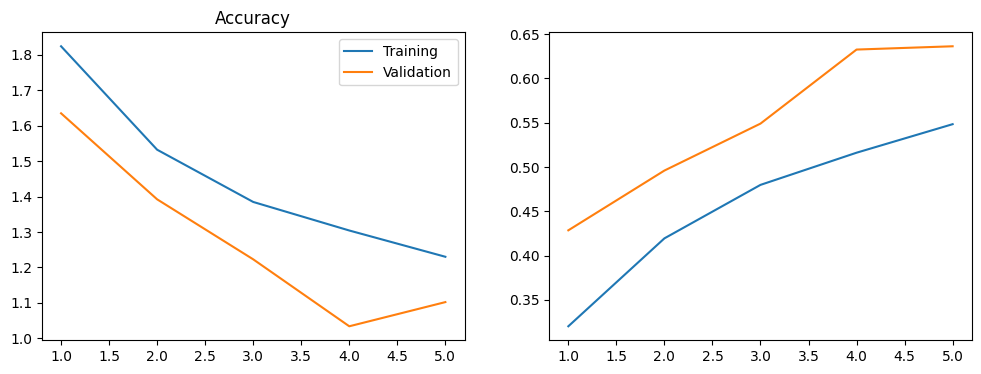

In [ ]:
plot_loss_acc(aug_history,5)

In [ ]:
#pre-trained 모델을 사전 학습된 가중치와 함께 가져오기

from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top = False,
                              weights='imagenet',
                              input_shape=[64,64,3])
pre_trained_base.trainable = False

from tensorflow.keras.utils import plot_model
plot_model(pre_trained_base,show_shapes = True,show_layer_names=True,to_file='resnet50.png')

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
#Top층에 Classification 추가

def build_transfer_classifier():
  model = tf.keras.Sequential([
      pre_trained_base,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128,activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64,activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
  ])

  return model

tc_model = build_transfer_classifier()
tc_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 2, 2, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,622,410 (93.93 MB)

 Trainable params: 1,057,610 (4.03 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
tc_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

tc_history = tc_model.fit(train_data,
                          validation_data=valid_data,
                          epochs=5)

Epoch 1/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 229s 663ms/step - accuracy: 0.6295 - loss: 1.1486 - val_accuracy: 0.8330 - val_loss: 0.5342
Epoch 2/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 261s 772ms/step - accuracy: 0.8101 - loss: 0.5897 - val_accuracy: 0.8424 - val_loss: 0.4915
Epoch 3/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 260s 768ms/step - accuracy: 0.8522 - loss: 0.4461 - val_accuracy: 0.8496 - val_loss: 0.4731
Epoch 4/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 259s 759ms/step - accuracy: 0.8814 - loss: 0.3613 - val_accuracy: 0.8530 - val_loss: 0.4786
Epoch 5/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 264s 764ms/step - accuracy: 0.8936 - loss: 0.3172 - val_accuracy: 0.8524 - val_loss: 0.4918


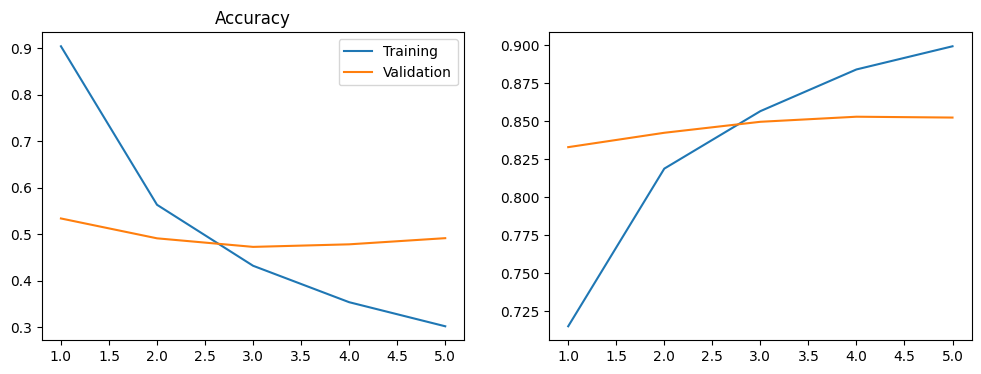

In [ ]:
plot_loss_acc(tc_history,5)